# MCMC Inversion Kernels

In [1]:
from mesa_tricks.io.eigensystem import Eigensystem
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import trapz, cumtrapz
from scipy.optimize import least_squares, minimize

from os import system
from mesa_tricks.io import read_gyre

GYRE = "~/Git/gyre/bin/gyre"

def globs_from_info(info):
    from astropy import units as u, constants as c
    M = (info['M'] * u.g / c.M_sun).to(1).value
    R = (info['R'] * u.cm / c.R_sun).to(1).value
    L = info['L'] * u.erg / u.s
    T = np.power(L / (4 * np.pi * (R * u.R_sun)**2 * c.sigma_sb), 1/4).to(u.K).value / 5777
    return 135 * np.sqrt(M / R**3), 3090 * M / R**2 / np.sqrt(T)

def pulse(gyrefile, worker="temp", degree=1):
    info, gyre = read_gyre(gyrefile)
    Δν, νmax = globs_from_info(info)

    outdir = gyrefile.replace(".GYRE", f"-{degree}")
    system(f"mkdir -p {outdir}")
    with open("π.template", "r") as f:
        template = ''.join(f.readlines())
        
    with open(f"{worker}.in", "w") as f:
        f.write(template.format(
            fname=gyrefile,
            outdir=outdir,
            minfreq=max(Δν, νmax - 6 * Δν),
            maxfreq=νmax + 6 * Δν,
            degree=degree
        ))
    system(f"{GYRE} {worker}.in > /dev/null")

In [2]:
from tqdm.auto import tqdm
from os.path import isfile

f = "1099_90.data.GYRE"
for l in (1, 2):
    if not isfile(f.replace(".GYRE", f'-{l}/freqs.dat-π')):
        pulse(f, degree=l)
        
from rotation import rot_kernel

def K(eig, i, l):
    M = float(eig._info[0]['M_star'])
    R = float(eig._info[0]['R_star'])
    return 4 * np.pi * eig.r**2 * eig.ρ0 * rot_kernel(eig.ξ[i], eig.ξh[i], eig.ξ[i],
                                                      eig.ξh[i], l, 1) / (M * R**2) / 2

In [3]:
# load MCMC results

checkpoint = 'pooled_rot.npy'
MCMC = np.load(checkpoint, allow_pickle=True)[()]['summary']

if 'lw' in checkpoint:
    δν1 = MCMC['new_samples'][:,5]
    δν2 = MCMC['new_samples'][:,6]
    
    Γ1 = MCMC['new_samples'][:,1][:, None]
    Γ2 = MCMC['new_samples'][:,1][:, None]
    
    i = 1

else:
    δν1 = MCMC['new_samples'][:,4]
    δν2 = MCMC['new_samples'][:,5]
    
    Γ1 = MCMC['new_samples'][:,41:46]
    Γ2 = MCMC['new_samples'][:,46:51]
    
    i = 0

# mode frequencies

ν1 = MCMC['new_samples'][:,11+i:16+i]
ν2 = MCMC['new_samples'][:,16+i:21+i]

# mode amplitudes

A1 = MCMC['new_samples'][:,26+i:31+i]
A2 = MCMC['new_samples'][:,31+i:36+i]

# Derived quantities: integrated power = H * Γ

P1 = A1
P2 = A2

In [4]:
# evaluate actual rotational kernels

from scipy.integrate import cumtrapz

eig1 = Eigensystem("1099_90.data-1/π.*.txt")
K1 = np.array([K(eig1, i, 1) for i in range(2, 7)])
I1 = np.array([cumtrapz(K, eig1.r, initial=0) for K in K1])
β1 = np.array([I[-1] for I in I1])

eig2 = Eigensystem("1099_90.data-2/π.*.txt")
K2 = np.array([K(eig2, i, 2) for i in range(3, 8)])
I2 = np.array([cumtrapz(K, eig2.r, initial=0) for K in K2])
β2 = np.array([I[-1] for I in I2])

def get_t(eig):
    cs = np.sqrt(eig.P0 * eig.Γ1 / eig.ρ0)
    return cumtrapz(1/cs, eig.r, initial=0)

t1 = get_t(eig1)
t2 = get_t(eig2)

T = max(t1[-1], t2[-1])
t1 /= T
t2 /= T

r1 = eig1.r / float(eig1._info[0]['R_star'])
r2 = eig2.r / float(eig1._info[0]['R_star'])

meas1 = np.sqrt(eig1.P0 * eig1.Γ1 / eig1.ρ0) * T
meas2 = np.sqrt(eig2.P0 * eig2.Γ1 / eig2.ρ0) * T

In [5]:
# For each sample from the joint distribution,
# compute the coefficients for the modes that yield
# the effective averaging kernels. These are weighted
# by the integrated power P = H * Γ of the modes.

w1 = P1 / np.sum(P1, axis=1)[:, None]
w2 = P2 / np.sum(P2, axis=1)[:, None]

βeff1 = np.sum(β1[None, :] * w1, axis=1)
βeff2 = np.sum(β2[None, :] * w2, axis=1)

In [6]:
# let's actually generate a bunch of rotational kernels

from tqdm.auto import tqdm

x = np.linspace(0, 1, 3000)
y1 = []
y2 = []
yy = []
kk = []
αα = []

x1s = []
x2s = []

for i in tqdm(range(len(δν1))):

    Keff1 = np.sum(w1[i][:, None] * K1, axis=0) / βeff1[i]
    Keff2 = np.sum(w2[i][:, None] * K2, axis=0) / βeff2[i]

    Ieff1 = np.sum(w1[i][:, None] * I1, axis=0) / βeff1[i]
    Ieff2 = np.sum(w2[i][:, None] * I2, axis=0) / βeff2[i]
    
    y1.append(np.interp(x, t1, Ieff1))
    y2.append(np.interp(x, t2, Ieff2))

    yy.append(np.interp(x, t2, Ieff2) - np.interp(x, t1, Ieff1))
    kk.append(np.interp(x, t2, Keff2 * meas2) - np.interp(x, t1, Keff1 * meas1))
#     αα.append(trapz(np.maximum(0, kk[-1]), x))
    αα.append(trapz(np.maximum(0, np.gradient(yy[-1], x)), x))
#     x1s.append(trapz(np.maximum(0, x*np.gradient(yy[-1], x)), x) / trapz(np.maximum(0, np.gradient(yy[-1], x)), x))
#     x2s.append(trapz(np.minimum(0, x*np.gradient(yy[-1], x)), x) / trapz(np.minimum(0, np.gradient(yy[-1], x)), x))

    x1s.append(trapz(t1 * Keff1 * meas1, t1)/trapz(Keff1 * meas1, t1))
    x2s.append(trapz(t2 * Keff2 * meas2, t2)/trapz(Keff2 * meas2, t2))

  0%|          | 0/41752 [00:00<?, ?it/s]

/tmp/ipykernel_41766/629548445.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return np.nan_to_num(l * (l+1) * cs2 / eig.r**2, nan=np.inf)
/tmp/ipykernel_41766/629548445.py:10: RuntimeWarning: overflow encountered in true_divide
  tturn1 = t1[np.argmin((1 - S12/ω0**2)**2)]
/tmp/ipykernel_41766/629548445.py:11: RuntimeWarning: overflow encountered in true_divide
  tturn2 = t2[np.argmin((1 - S22/ω0**2)**2)]


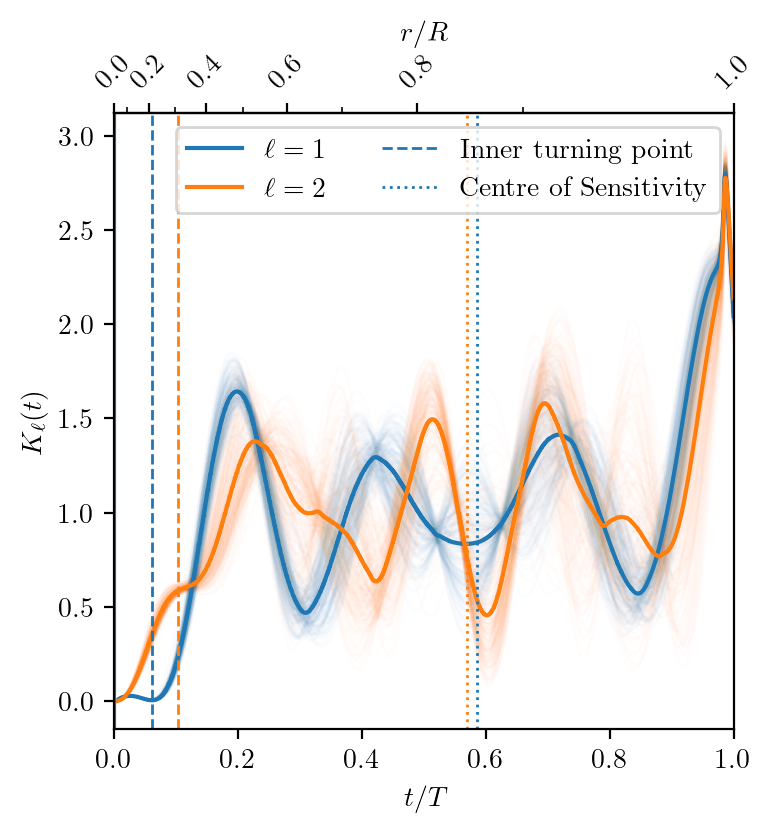

In [7]:
# inner turning points for dipole and quadrupole modes

ω0 = 7.5 / 1e6 * 2 * np.pi
def Lamb(l, eig):
    cs2 = eig.P0 * eig.Γ1 / eig.ρ0
    return np.nan_to_num(l * (l+1) * cs2 / eig.r**2, nan=np.inf)
S12 = Lamb(1, eig1)
S22 = Lamb(2, eig2)

tturn1 = t1[np.argmin((1 - S12/ω0**2)**2)]
tturn2 = t2[np.argmin((1 - S22/ω0**2)**2)]

for i in range(0, len(y1), 200):
    plt.plot(x, np.gradient(y1[i], x), alpha=.01, c='C0', lw=1)
    plt.plot(x, np.gradient(y2[i], x), alpha=.01, c='C1', lw=1)
    
plt.plot(x, np.median(np.gradient(y1, x, axis=1), axis=0), label='$\ell=1$')
plt.plot(x, np.median(np.gradient(y2, x, axis=1), axis=0), label='$\ell=2$')

# z1 = 1-2*(1-np.median(x1s))
# z2 = 1-2*(1-np.median(x2s))

z1 = np.median(1-2*(1-np.array(x1s)))
z2 = np.median(1-2*(1-np.array(x2s)))

# plt.plot(x, np.where(x < z1, 0, 1/(1-z1)), c='C0', ls='dotted', lw=1, label='Boxcar')
# plt.plot(x, np.where(x < z2, 0, 1/(1-z2)), c='C1', ls='dotted', lw=1)

plt.axvline(tturn1, lw=1, ls='dashed', label="Inner turning point")
plt.axvline(tturn2, c='C1', lw=1, ls='dashed')

plt.axvline(np.median(x1s), lw=1, ls='dotted', label='Centre of Sensitivity')
plt.axvline(np.median(x2s), c='C1', lw=1, ls='dotted')

plt.axvline()

plt.legend(ncol=2)
plt.xlim(0, 1)

plt.xlabel(r"$t/T$")
plt.ylabel(r"$K_\ell(t)$")

# secondary x-xaxis

secax = plt.gca().secondary_xaxis('top', functions=(lambda x: np.interp(x, t1, r1),
                                                    lambda x: np.interp(x, r1, t1)))
from matplotlib.ticker import FixedLocator
secax.set_xlabel('$r/R$')
for tick in secax.get_xticklabels():
    tick.set_rotation(45)
secax.xaxis.set_minor_locator(FixedLocator(np.arange(5)*.2+.1))

plt.gcf().set_size_inches(4,4)
for ext in ('png', 'pdf'):
    plt.savefig(f"raw_kernel.{ext}", bbox_inches='tight',
                transparent=True, dpi=300)

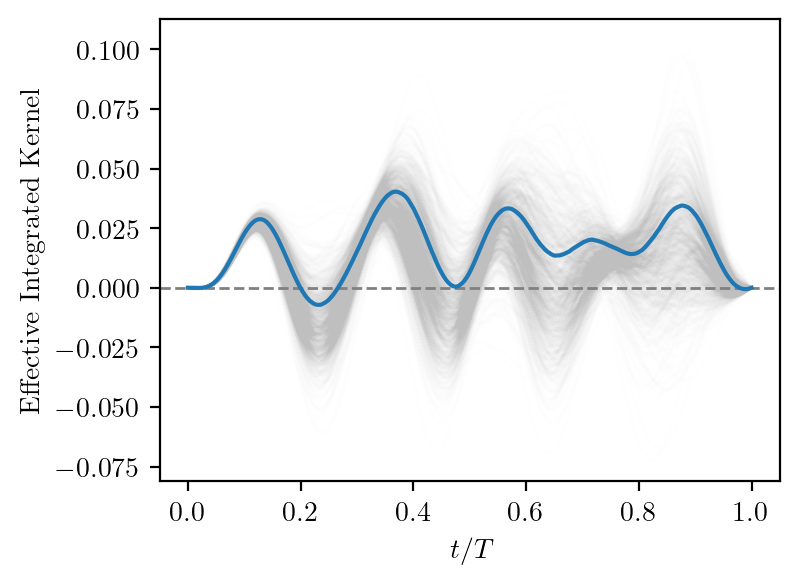

In [84]:
for i in range(-1000, -1):
    plt.plot(x, yy[i], c=(.75, .75, .75), alpha=.01, lw=1)
    
plt.ylabel(r"Effective Integrated Kernel")
plt.xlabel(r"$t/T$")
plt.axhline(0, ls='dashed', lw=1, c='gray')
plt.plot(x, np.median(yy, axis=0))

plt.gcf().set_size_inches(4,3)
plt.savefig(r"effective_integral.pdf", bbox_inches='tight')

In [85]:
trapz(np.median(yy, axis=0), x)

0.016735905677467515

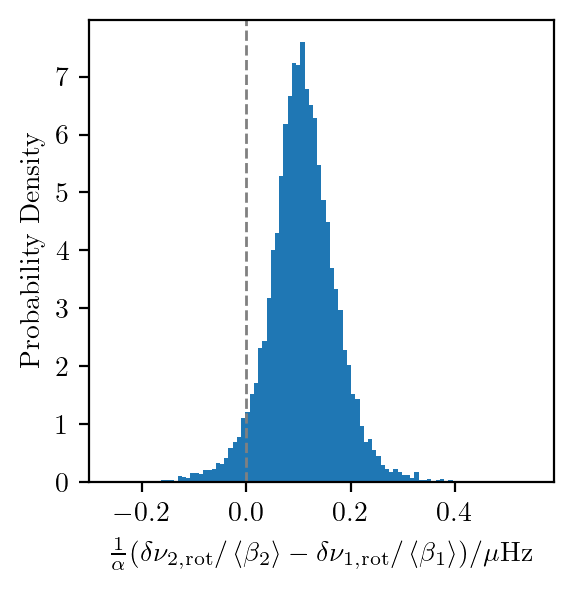

In [92]:
plt.hist(1/np.array(αα) * (δν2/βeff2 - δν1/βeff1), density=True, bins=100)
plt.ylabel(r"Probability Density")
plt.xlabel(r"${1 \over \alpha}(\delta\nu_{2, \text{rot}}/\left<\beta_2\right> - \delta\nu_{1, \text{rot}}/\left<\beta_1\right>)/\mu$Hz")

plt.axvline(0, ls='dashed', c='gray', lw=1)

plt.gcf().set_size_inches(3,3)
plt.savefig(r"shear.pdf", bbox_inches='tight', transparent=True)
plt.show()

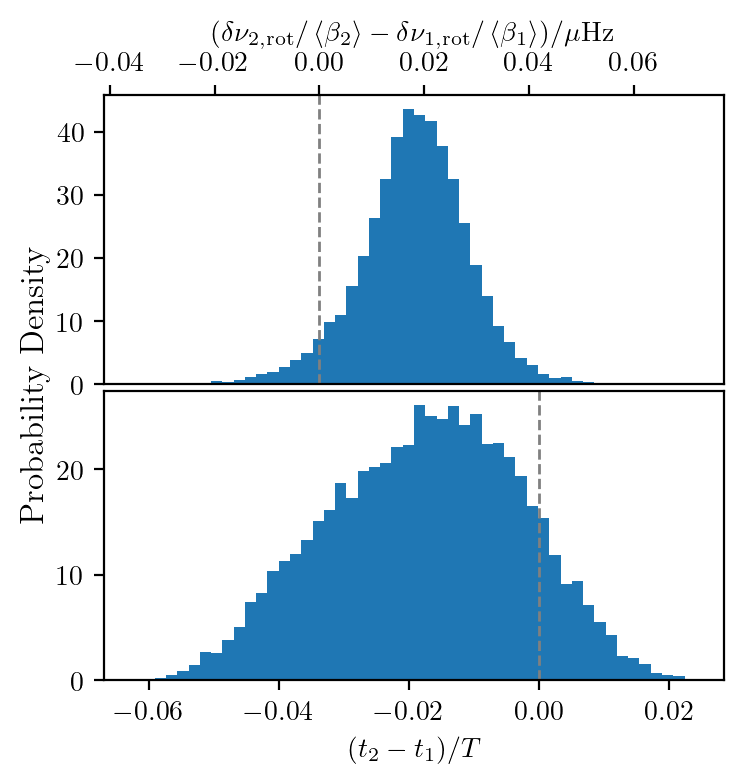

In [8]:
f, ax = plt.subplots(2,1, squeeze=True)
plt.sca(ax[0])
plt.hist((δν2/βeff2 - δν1/βeff1), density=True, bins=50)
plt.axvline(0, ls='dashed', c='gray', lw=1)
plt.xlabel(r"$(\delta\nu_{2, \text{rot}}/\left<\beta_2\right> - \delta\nu_{1, \text{rot}}/\left<\beta_1\right>)/\mu$Hz")
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

plt.sca(ax[1])
plt.hist(np.array(x2s)-np.array(x1s), density=True, bins=50)
plt.xlabel(r"$(t_2 - t_1)/T$")
plt.axvline(0, ls='dashed', c='gray', lw=1)

plt.gcf().supylabel(r"Probability Density")
plt.subplots_adjust(hspace=.025)
plt.gcf().set_size_inches(4,3.8)
plt.savefig(r"shear.pdf", bbox_inches='tight', transparent=True)
plt.show()